<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [2]:
#Installing required library
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [17]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Load preprocessed data
df = pd.read_csv('preprocessed_bitcoin_data.csv', index_col='Date', parse_dates=True)

# Display the first few rows of the data
df.head()

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-32.894012
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-29.644012
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,14.108002
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-10.082977
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600,3.330994


## 2. Data Preprocessing

In [5]:
# Select only 'Close' column for prediction
data = df[['Close']].values  # Convert to NumPy array

#### Normalize Data:

In [6]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

#### Create Sequences:

In [7]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [8]:
seq_length = 60  # Use last 60 days to predict next day
X, y = create_sequences(data_scaled, seq_length)

#### Split into Training and Testing Sets:

In [9]:
# Split into training and testing sets
split = int(0.8 * len(X))   # 20% for validation
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

#### Reshape Data for LSTM:
LSTM expects input in 3D format: (samples, timesteps, features)

In [10]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [11]:
X_train.shape

(2985, 60, 1)

## 3. Define the LSTM Model

In [14]:
# Define the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='linear'))  # 'linear' for regression

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Print model summary to check the architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',
              loss='mean_squared_error',  # MSE is a common loss for regression
              metrics=['mae', 'mse'])

## 4. Train the Model

In [18]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(X, y, epochs=50, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], shuffle=True)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0056 - mae: 0.0414 - mse: 0.0056 - val_loss: 0.0016 - val_mae: 0.0327 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.3122e-04 - mae: 0.0161 - mse: 8.3122e-04 - val_loss: 0.0037 - val_mae: 0.0472 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4428e-04 - mae: 0.0146 - mse: 6.4428e-04 - val_loss: 0.0017 - val_mae: 0.0289 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.2352e-04 - mae: 0.0139 - mse: 6.2352e-04 - val_loss: 0.0015 - val_mae: 0.0266 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2591e-04 - mae: 0.0127 - mse: 5.2591e-04 - val_loss: 6.0559e-04 - val_mae: 0.0174 - val_mse: 6.0559e-04 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3370e-04 - mae: 0.0129 - mse: 5.33

## 5. Evaluate the Model
Check the performance on the test data.

In [19]:
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1159e-04 - mae: 0.0104 - mse: 2.1159e-04
Test Loss: 0.00043445327901281416, Test MAE: 0.014718744903802872, Test MSE: 0.00043445327901281416


In [22]:
# Predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Inverse scale predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scale actual values

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


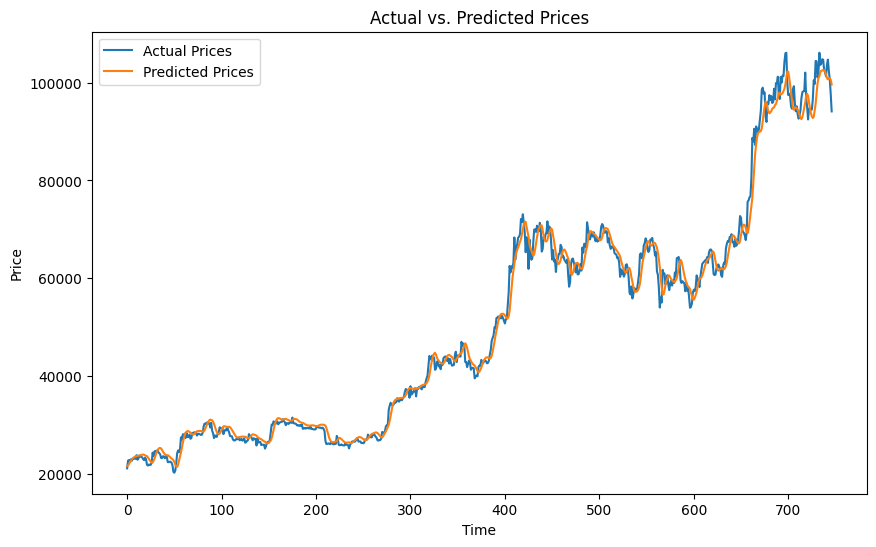

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predicted, label="Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

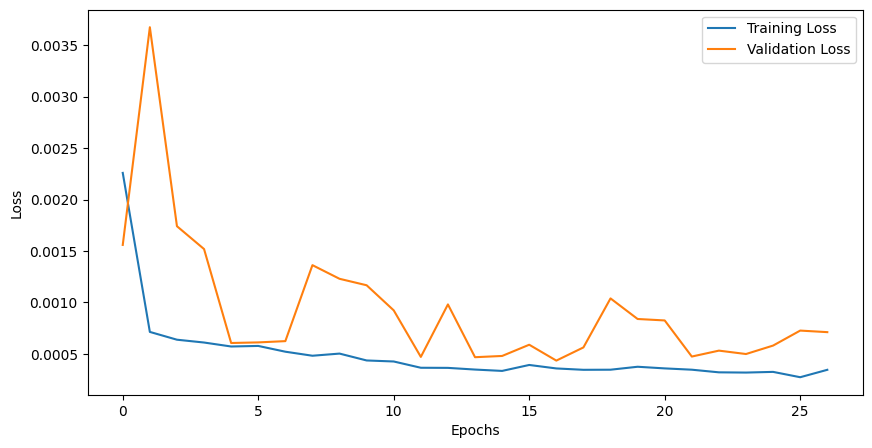

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


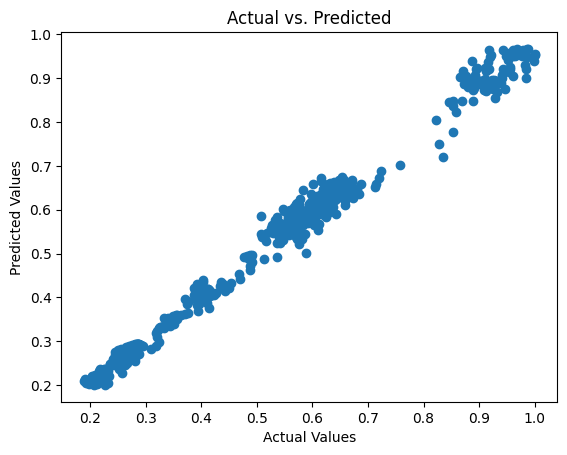

In [21]:
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()